## 既存のレイヤーにデータを追加する


#### 各種パッケージのインポート

In [7]:
# パッケージ等 import 処理
import urllib.request
from arcgis.gis import GIS

import pandas as pd
from datetime import datetime as dt

import pytz

#### ArcGIS Online にログイン


In [8]:
user_name = "ユーザー名を入力"
user_pass = "パスワードを入力" 

In [10]:
# ArcGIS Onlineにログイン
gis = GIS(username=user_name,password=user_pass)

#### 追加データのクレンジング

In [11]:
# 登録用の日時を取得する
now_datetime = dt.now(pytz.timezone('Asia/Tokyo'))
now = now_datetime.strftime("%Y%m%d_%H%M")

now

'20220224_1446'

In [12]:
# 準備していた座標結合用のデータを取得する
amedas_location = pd.read_csv('/arcgis/home/アメダス座標一覧.csv')

# 気象庁からアメダスの 1 時間ごとのデータをダウンロード
# ファイル名に上記で取得した日時を利用する
url = "https://www.data.jma.go.jp/obd/stats/data/mdrr/pre_rct/alltable/pre1h00_rct.csv"
dataFile = "/arcgis/home/" + now + ".csv"
urllib.request.urlretrieve(url, dataFile)

# ダウンロードしたファイルから、観測所番号と降雨量の現在値のみ取得
amedasdata = pd.read_csv(dataFile, encoding = "shift-jis", usecols=["観測所番号", "現在値(mm)"])

# 降雨量が 1mm より多いデータのみ抽出しつつ、座標結合用のファイルと結合する
result=pd.merge(amedas_location,amedasdata[amedasdata['現在値(mm)'] > 1], on='観測所番号', how="inner")

# 結合結果に対して、取得日時の列を追加する
result["取得日時"] = now_datetime.strftime("%Y/%m/%d %H:%M:%S")

In [13]:
# 追加用 CSV を出力する(ダウンロードしたファイルに上書き)
amedasCSV = ('/arcgis/home/' + now +'.csv')
result.to_csv(amedasCSV)

In [14]:
# CSV ファイルを GIS ポータルのアイテムとしてアップロード
title = "appendData"+ now
tags = "アメダス"
itemtype = "CSV"
item_props = {"type":itemtype,"tags":tags,"title":title}

append_CSV = gis.content.add(item_properties = item_props, data = amedasCSV)
append_CSV

<Item title:"appendData20220224_1446" type:CSV owner:ejnagaiA>

#### 更新対象のレイヤーを取得する

<Item title:"append用レイヤー" type:Feature Layer Collection owner:ejnagaiA>
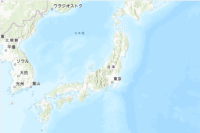

In [15]:
# アイテム ID を利用してレイヤーを検索
itemID = "アイテム ID を入力"

layer = gis.content.search(query="id:" + itemID)[0]
layer

In [16]:
# データを追加する FeatureLayer クラスのインスタンスを取得
fl = layer.layers[0]
fl

<FeatureLayer url:"https://services.arcgis.com/wlVTGRSYTzAbjjiC/arcgis/rest/services/アメダステスト/FeatureServer/0">

#### 追加処理の実行

In [18]:
# append メソッドを実行する
fl.append(
    item_id = append_CSV.id,
    upload_format="csv",
    upsert=False,
    source_info =gis.content.analyze(item = append_CSV.id)['publishParameters']
)

True